In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.inception import InceptionScore
import torch.nn.functional as F
import pandas as pd

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data loading and preprocessing

In [2]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=128, shuffle=True)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=128, shuffle=False)

# Models definitions

## Generator

In [3]:

class Generator(nn.Module):
    def __init__(self, z_dim=100, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(True),
            
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(True),
            
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(True),
            
            nn.Linear(1024, img_dim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.net(x)

## Discriminator

In [4]:

class Discriminator(nn.Module):
    def __init__(self, img_dim=28*28):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(img_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

# Define functions to evaluate the models during training

In [5]:

def generate_and_plot_images(generator, fixed_noise, epoch):
    generator.eval()
    with torch.no_grad():
        gen_imgs = generator(fixed_noise).view(-1, 1, 28, 28)
        gen_imgs = gen_imgs.cpu().numpy()
        
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        axes = axes.flatten()
        for i, (img, ax) in enumerate(zip(gen_imgs, axes)):
            ax.imshow((img.squeeze() + 1) / 2, cmap='gray')
            ax.axis('off')
            ax.set_title(f'Img {i+1}', fontsize=8)
        plt.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()


def evaluate_on_test_set(generator, discriminator, test_loader, criterion, z_dim, device):
    generator.eval()
    discriminator.eval()
    
    test_loss_disc = 0
    test_loss_gen = 0
    test_batches = 0
    
    with torch.no_grad():
        for real_test, _ in test_loader:
            real_test = real_test.view(-1, 28*28).to(device)
            batch_size_test = real_test.size(0)
            
            label_real_test = torch.ones(batch_size_test, 1, device=device)
            label_fake_test = torch.zeros(batch_size_test, 1, device=device)
            
            # Generate fake images
            noise_test = torch.randn(batch_size_test, z_dim, device=device)
            fake_test = generator(noise_test)
            
            # Calculate Discriminator loss
            loss_disc_real = criterion(discriminator(real_test), label_real_test)
            loss_disc_fake = criterion(discriminator(fake_test), label_fake_test)
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            
            # Calculate Generator loss
            output = discriminator(fake_test)
            loss_gen = criterion(output, label_real_test)
            
            test_loss_disc += loss_disc.item()
            test_loss_gen += loss_gen.item()
            test_batches += 1
    
    avg_test_loss_disc = test_loss_disc / test_batches
    avg_test_loss_gen = test_loss_gen / test_batches
    
    return {
        'loss_disc': avg_test_loss_disc,
        'loss_gen': avg_test_loss_gen
    }


def calculate_fid(generator, fid_metric, real_loader, z_dim, device, n_samples=100):
    generator.eval()
    fid_metric.reset()
    
    real_list = []
    with torch.no_grad():
        for real, _ in real_loader:
            real_rgb = real.repeat(1, 3, 1, 1)
            real_299 = F.interpolate(real_rgb, size=(299, 299), mode='bilinear')
            real_299 = ((real_299 + 1) / 2 * 255).clamp(0, 255).byte()
            real_list.append(real_299)
            if len(real_list) * real.size(0) >= n_samples:
                break
    
    real_images = torch.cat(real_list, dim=0)[:n_samples]
    fid_metric.update(real_images, real=True)
    
    batch_size = 50
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            bs = min(batch_size, n_samples - i)
            noise = torch.randn(bs, z_dim, device=device)
            fake = generator(noise).view(-1, 1, 28, 28)
            fake_rgb = fake.repeat(1, 3, 1, 1)
            fake_299 = F.interpolate(fake_rgb, size=(299, 299), mode='bilinear')
            fake_299 = ((fake_299 + 1) / 2 * 255).clamp(0, 255).byte().cpu()
            fid_metric.update(fake_299, real=False)
            
            del noise, fake, fake_rgb, fake_299
    
    return fid_metric.compute().item()


def evaluate_gan(generator, discriminator, fid_metric, test_loader, criterion, fixed_noise, z_dim, epoch, device):
    print(f"\n{'='*60}")
    print(f"📊 Evaluating at Epoch {epoch}")
    print(f"{'='*60}")
    
    generate_and_plot_images(generator, fixed_noise, epoch)    
    test_metrics = evaluate_on_test_set(generator, discriminator, test_loader, criterion, z_dim, device)
    fid = calculate_fid(generator, fid_metric, test_loader, z_dim, device)
    
    print(f"\n📈 Test Set Evaluation:")
    print(f"  • Discriminator loss: {test_metrics['loss_disc']:.4f}")
    print(f"  • Generator loss: {test_metrics['loss_gen']:.4f}")
    print(f"  • FID: {fid:.2f}")
    print(f"{'='*60}\n")
    
    return test_metrics, fid

# Training

In [6]:

def train_disc(discriminator, generator, real, criterion, optimizer_disc, z_dim, device, curr_epoch, total_epochs):
    batch_size = real.size(0)
    
    label_real = torch.ones(batch_size, 1, device=device) * 0.9
    label_fake = torch.zeros(batch_size, 1, device=device)

    progress = curr_epoch / total_epochs
    noise_strength = 0.15 * ((1 - progress) ** 3)
    real_noisy = real + noise_strength * torch.randn_like(real)
    
    noise = torch.randn(batch_size, z_dim, device=device)
    noise = torch.clamp(noise, -2.0, 2.0)
    fake = generator(noise)
    
    loss_disc_real = criterion(discriminator(real_noisy), label_real)
    loss_disc_fake = criterion(discriminator(fake.detach()), label_fake)
    loss_disc = (loss_disc_real + loss_disc_fake) / 2

    optimizer_disc.zero_grad()
    loss_disc.backward()
    optimizer_disc.step()

    return loss_disc.item()


def train_gen(generator, discriminator, real, criterion, optimizer_gen, z_dim, device):
    batch_size = real.size(0)
    label_real = torch.ones(batch_size, 1, device=device)
    
    noise = torch.randn(batch_size, z_dim, device=device)
    noise = torch.clamp(noise, -2.0, 2.0)
    fake = generator(noise)
    
    output = discriminator(fake)
    loss_gen = criterion(output, label_real)

    optimizer_gen.zero_grad()
    loss_gen.backward()
    optimizer_gen.step()

    return loss_gen.item()

Epoch 0: Loss_D 0.6157279267494105, Loss_G 1.0842486203098094
Epoch 1: Loss_D 0.5721993563271789, Loss_G 1.4082644248822096
Epoch 2: Loss_D 0.5686243560903871, Loss_G 1.4863266914383944
Epoch 3: Loss_D 0.5809491210654855, Loss_G 1.3789319382039213
Epoch 4: Loss_D 0.5867573867982893, Loss_G 1.3465158653411784
Epoch 5: Loss_D 0.6003565359979804, Loss_G 1.2292253302612792
Epoch 6: Loss_D 0.6063825115720346, Loss_G 1.1897686128931513
Epoch 7: Loss_D 0.6173924558452452, Loss_G 1.1168885955424197
Epoch 8: Loss_D 0.6241759802741028, Loss_G 1.089524178616782
Epoch 9: Loss_D 0.630294860807309, Loss_G 1.0568869613381082

📊 Evaluating at Epoch 9


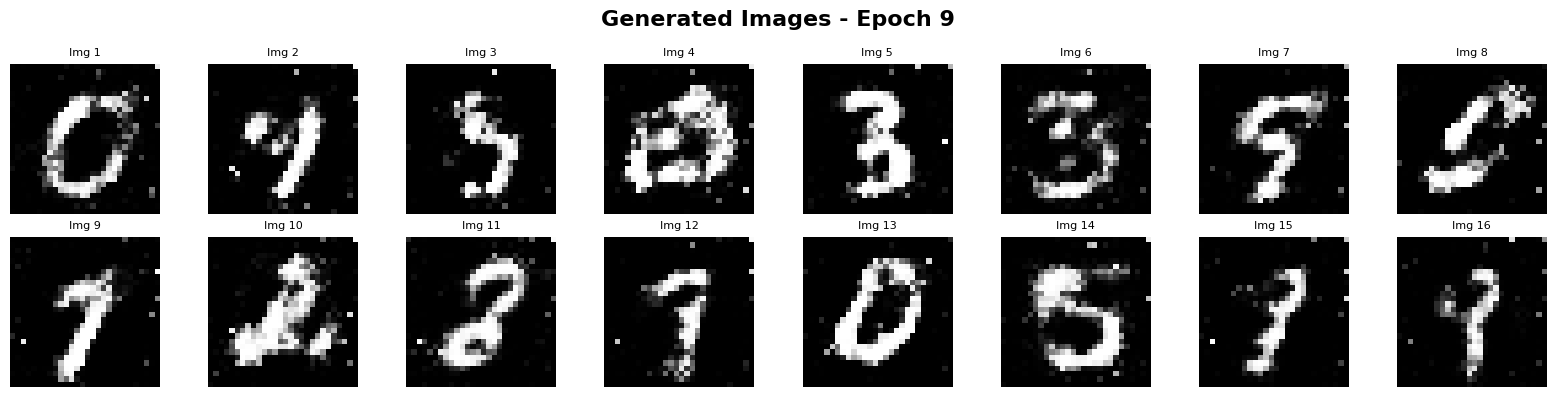


📈 Test Set Evaluation:
  • Discriminator loss: 0.5931
  • Generator loss: 0.9735
  • FID: 272.17

New best model saved! FID: 272.17
Epoch 10: Loss_D 0.6409757081379515, Loss_G 1.009901803439614
Epoch 11: Loss_D 0.6430893340852978, Loss_G 0.9920028836996571
Epoch 12: Loss_D 0.6463646907796229, Loss_G 0.9836336653878186
Epoch 13: Loss_D 0.6523475912588237, Loss_G 0.9694396831841865
Epoch 14: Loss_D 0.6586874690391361, Loss_G 0.9422349697237076
Epoch 15: Loss_D 0.6598013217515274, Loss_G 0.9277482863936597
Epoch 16: Loss_D 0.6641546680983196, Loss_G 0.9145193824381717
Epoch 17: Loss_D 0.6670993502968664, Loss_G 0.9059552066107549
Epoch 18: Loss_D 0.6699081483934479, Loss_G 0.8952765513076457
Epoch 19: Loss_D 0.6705712561668363, Loss_G 0.8925635965902414

📊 Evaluating at Epoch 19


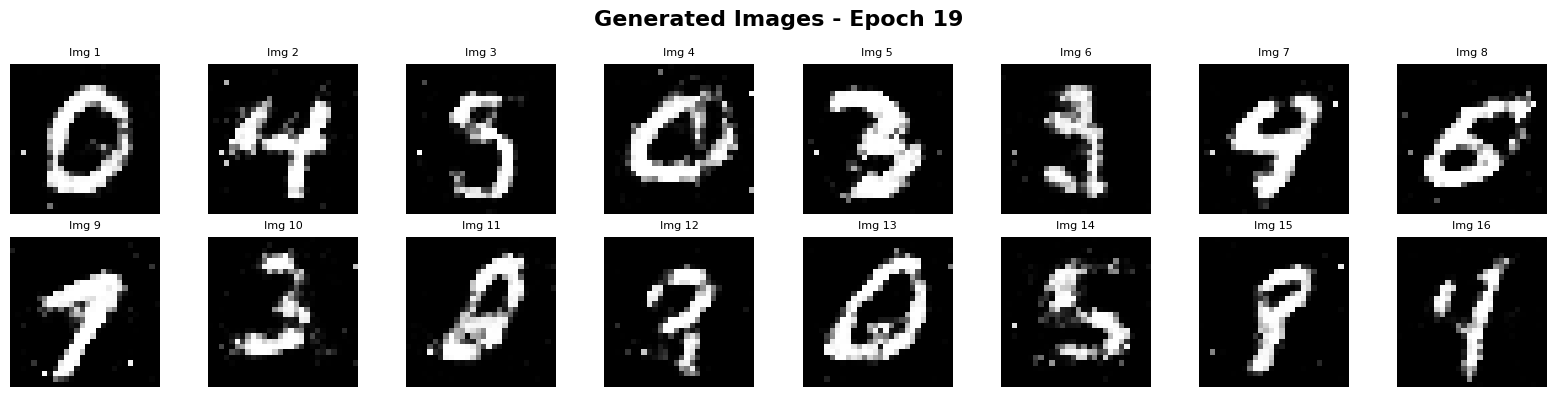


📈 Test Set Evaluation:
  • Discriminator loss: 0.6777
  • Generator loss: 0.8449
  • FID: 188.89

New best model saved! FID: 188.89
Epoch 20: Loss_D 0.6726229986402271, Loss_G 0.8847395059650641
Epoch 21: Loss_D 0.6742449102879587, Loss_G 0.879536233858259
Epoch 22: Loss_D 0.6751415957011648, Loss_G 0.8737057129711484
Epoch 23: Loss_D 0.6766911554438219, Loss_G 0.8685332119846141
Epoch 24: Loss_D 0.6772744378555559, Loss_G 0.8669066668065117
Epoch 25: Loss_D 0.6776143161218557, Loss_G 0.8651212749959055
Epoch 26: Loss_D 0.6786579834118581, Loss_G 0.8624211196452062
Epoch 27: Loss_D 0.6792961436548213, Loss_G 0.8562955936389183
Epoch 28: Loss_D 0.6796059866449726, Loss_G 0.8551075855043652
Epoch 29: Loss_D 0.6810576441699762, Loss_G 0.8507900335895482

📊 Evaluating at Epoch 29


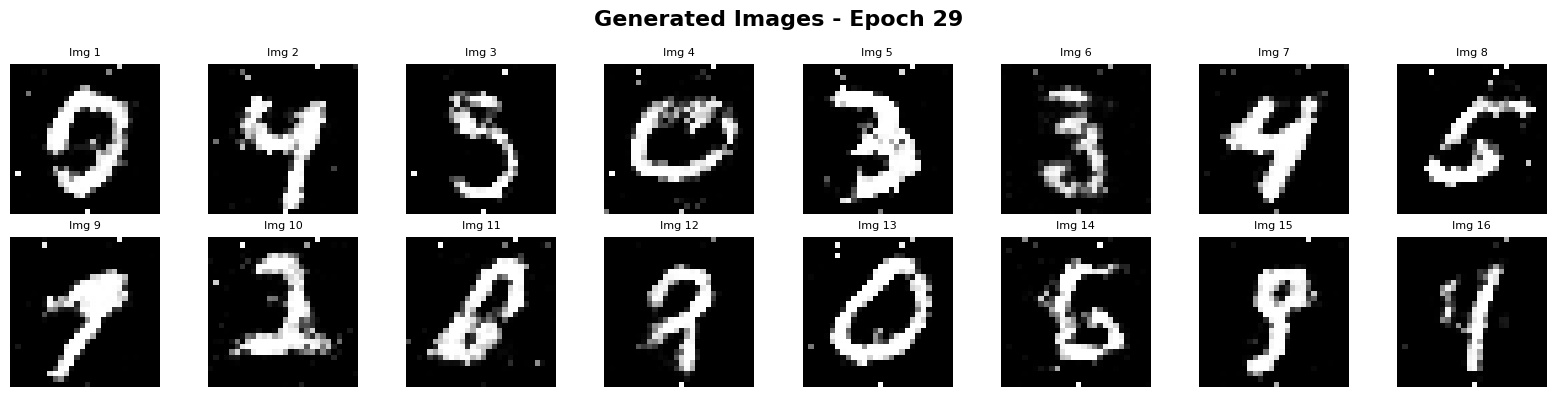


📈 Test Set Evaluation:
  • Discriminator loss: 0.7199
  • Generator loss: 0.9311
  • FID: 176.30

New best model saved! FID: 176.30
Epoch 30: Loss_D 0.6817609013270721, Loss_G 0.848371861077575
Epoch 31: Loss_D 0.6818521227409591, Loss_G 0.8432471185350723
Epoch 32: Loss_D 0.6825628153550853, Loss_G 0.844104159234175
Epoch 33: Loss_D 0.6822112132745511, Loss_G 0.8430167530645439
Epoch 34: Loss_D 0.683179206558382, Loss_G 0.8375723631397239
Epoch 35: Loss_D 0.6832473000992082, Loss_G 0.8391857860184936
Epoch 36: Loss_D 0.6836210240179034, Loss_G 0.8361695776107723
Epoch 37: Loss_D 0.6837299275499925, Loss_G 0.8328993042140628
Epoch 38: Loss_D 0.6840528845787048, Loss_G 0.8338582342875792
Epoch 39: Loss_D 0.6847684810410685, Loss_G 0.8315219095012526

📊 Evaluating at Epoch 39


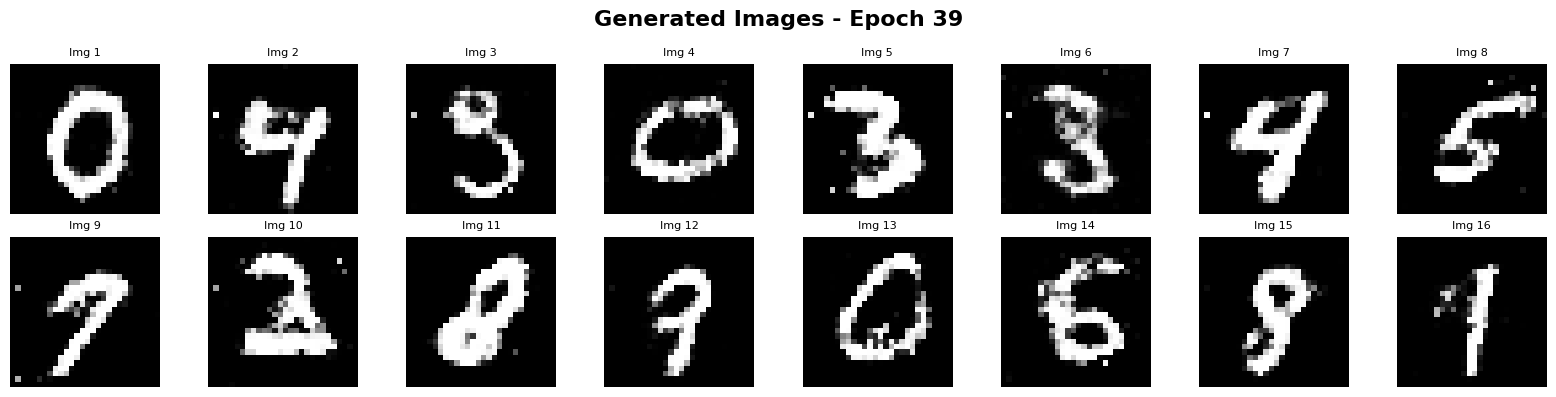


📈 Test Set Evaluation:
  • Discriminator loss: 0.6940
  • Generator loss: 0.8625
  • FID: 144.32

New best model saved! FID: 144.32
Epoch 40: Loss_D 0.6841579950186235, Loss_G 0.8284850644150268
Epoch 41: Loss_D 0.6841968732602053, Loss_G 0.8297976111806532
Epoch 42: Loss_D 0.6850095688661278, Loss_G 0.8300227280110438
Epoch 43: Loss_D 0.6848338714032285, Loss_G 0.8241328909707222
Epoch 44: Loss_D 0.6852875184148614, Loss_G 0.8243989832619868
Epoch 45: Loss_D 0.6857929064520895, Loss_G 0.8234851075642144
Epoch 46: Loss_D 0.6853312841102258, Loss_G 0.821736427766682
Epoch 47: Loss_D 0.6852625378413495, Loss_G 0.8224567042739153
Epoch 48: Loss_D 0.6857786578918571, Loss_G 0.8192916823856866
Epoch 49: Loss_D 0.6858770628727829, Loss_G 0.8193409670390555

📊 Evaluating at Epoch 49


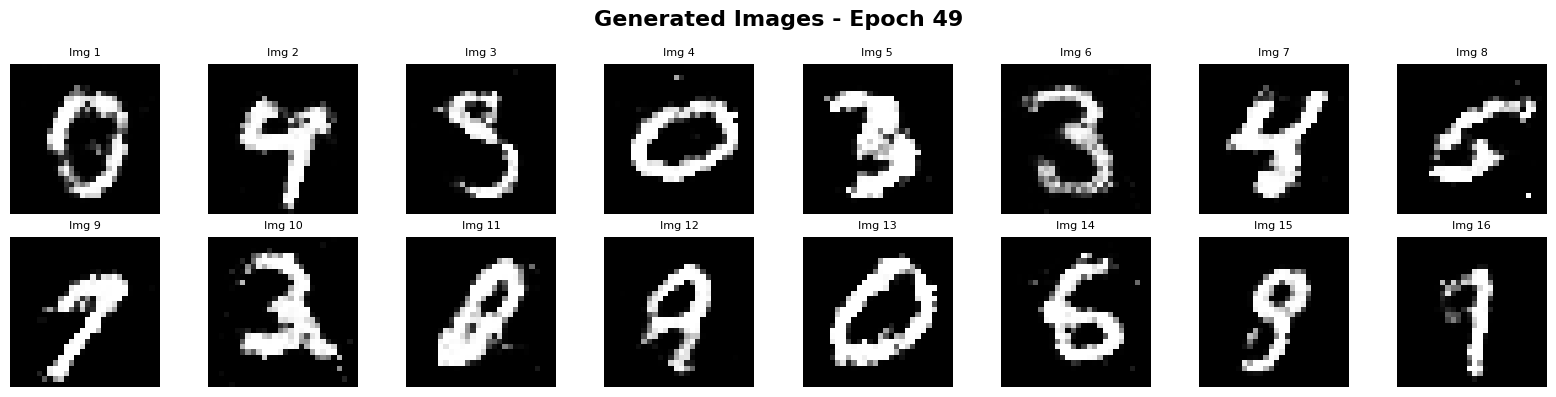


📈 Test Set Evaluation:
  • Discriminator loss: 0.6996
  • Generator loss: 0.8542
  • FID: 123.99

New best model saved! FID: 123.99
Epoch 50: Loss_D 0.6857819763073789, Loss_G 0.8184614800440986
Epoch 51: Loss_D 0.6861982642968835, Loss_G 0.8177444185021081
Epoch 52: Loss_D 0.68602971697667, Loss_G 0.8178871688303917
Epoch 53: Loss_D 0.6857275080833354, Loss_G 0.8195518556434208
Epoch 54: Loss_D 0.6860847728593009, Loss_G 0.8174664961503767
Epoch 55: Loss_D 0.6861472129821777, Loss_G 0.8172423075765435
Epoch 56: Loss_D 0.6864252042160359, Loss_G 0.8120128654721958
Epoch 57: Loss_D 0.6868205220460384, Loss_G 0.8157097753177065
Epoch 58: Loss_D 0.6866358345759703, Loss_G 0.8136217788592585
Epoch 59: Loss_D 0.6866275068285115, Loss_G 0.8124104423055263

📊 Evaluating at Epoch 59


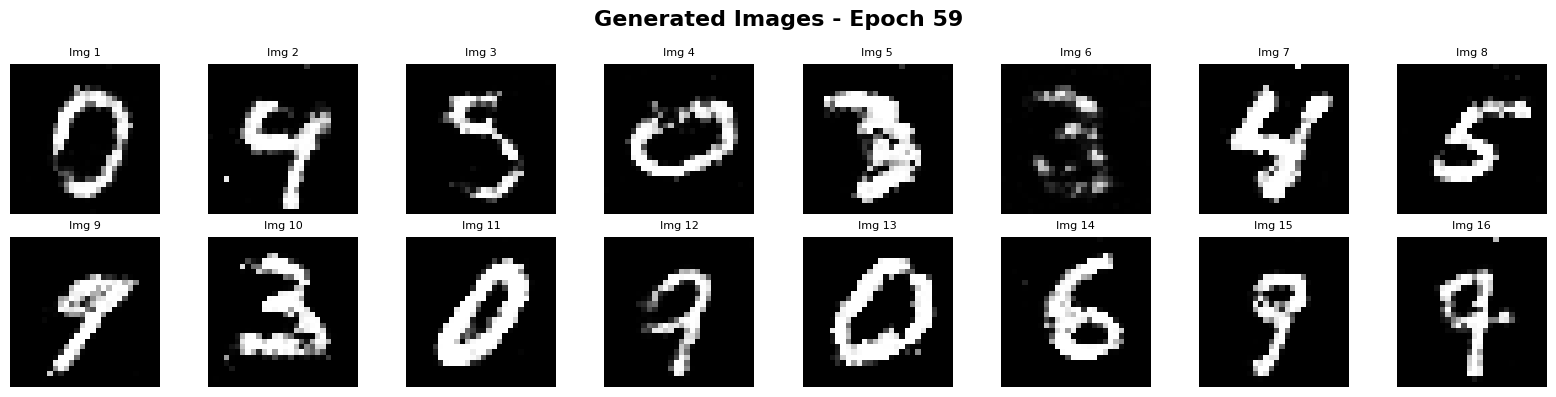


📈 Test Set Evaluation:
  • Discriminator loss: 0.6937
  • Generator loss: 0.8306
  • FID: 121.19

New best model saved! FID: 121.19
Epoch 60: Loss_D 0.6868314369400935, Loss_G 0.8122176858407857
Epoch 61: Loss_D 0.6869281334663505, Loss_G 0.8141139987180991
Epoch 62: Loss_D 0.6868929864246962, Loss_G 0.812111031144921
Epoch 63: Loss_D 0.6871106019660608, Loss_G 0.8123579365866525
Epoch 64: Loss_D 0.6868066966914927, Loss_G 0.8121252659795635
Epoch 65: Loss_D 0.6870446379250809, Loss_G 0.809938249176245
Epoch 66: Loss_D 0.6871277838627666, Loss_G 0.8101738402838392
Epoch 67: Loss_D 0.6873373094398075, Loss_G 0.8098509035893341
Epoch 68: Loss_D 0.687006190260336, Loss_G 0.8117833907670303
Epoch 69: Loss_D 0.6871756616431767, Loss_G 0.8105276613347312

📊 Evaluating at Epoch 69


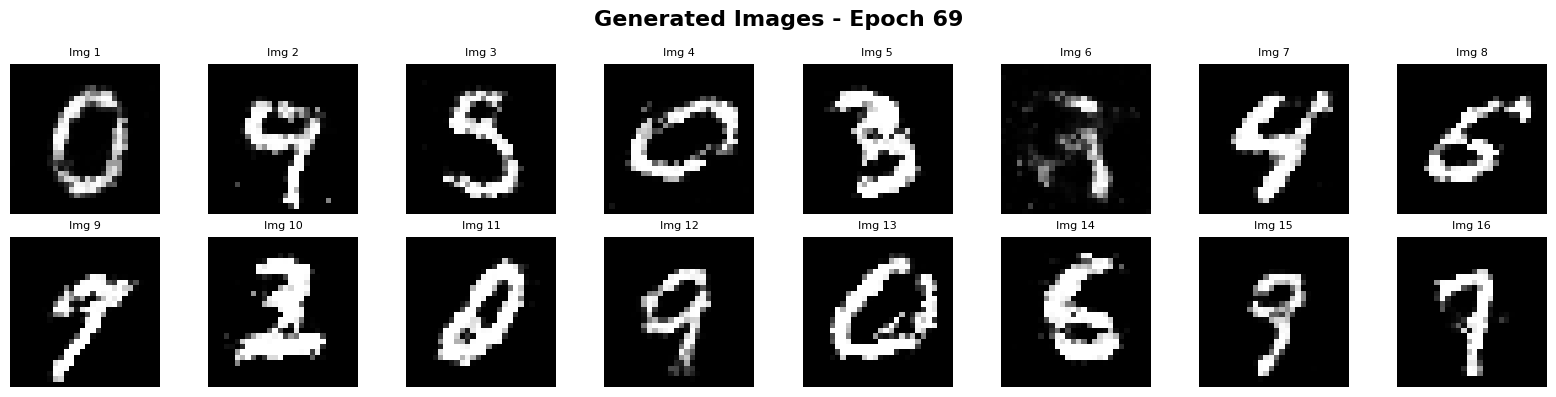


📈 Test Set Evaluation:
  • Discriminator loss: 0.6972
  • Generator loss: 0.7986
  • FID: 124.01

Epoch 70: Loss_D 0.6873371175357273, Loss_G 0.8083197485917667
Epoch 71: Loss_D 0.6874329684131435, Loss_G 0.8073517023119082
Epoch 72: Loss_D 0.6874676508181639, Loss_G 0.8077513402713133
Epoch 73: Loss_D 0.6874428692657047, Loss_G 0.8073031250347715
Epoch 74: Loss_D 0.6876256355344613, Loss_G 0.8095480244296954
Epoch 75: Loss_D 0.6875349209506882, Loss_G 0.8078425053848641
Epoch 76: Loss_D 0.687777921335021, Loss_G 0.8091061762146858
Epoch 77: Loss_D 0.6877811867545154, Loss_G 0.809170637939022
Epoch 78: Loss_D 0.6875820862713145, Loss_G 0.8079080779923559
Epoch 79: Loss_D 0.687830000162633, Loss_G 0.8048717882841635

📊 Evaluating at Epoch 79


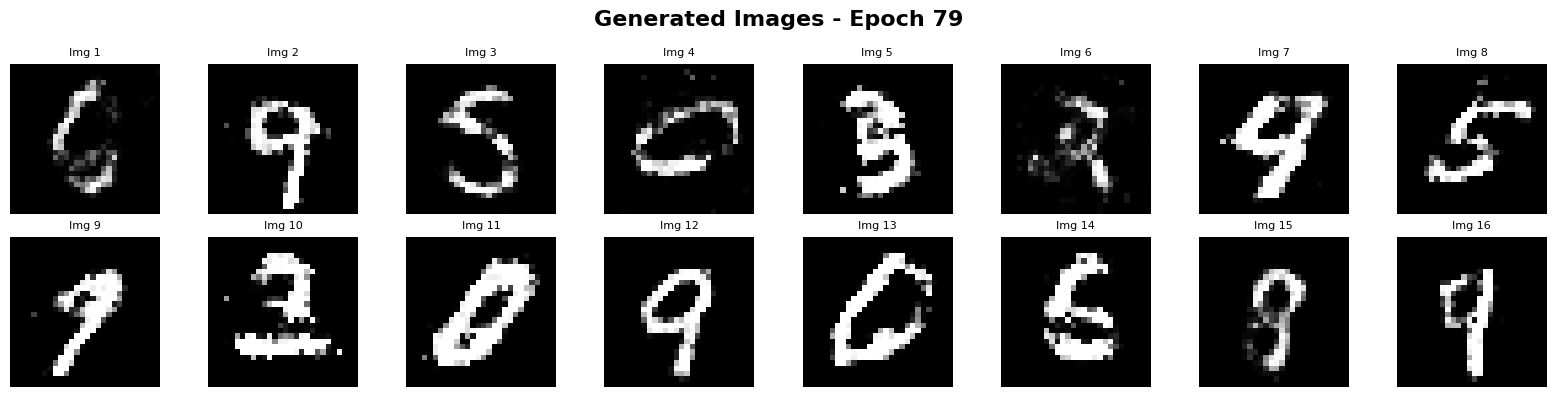


📈 Test Set Evaluation:
  • Discriminator loss: 0.6968
  • Generator loss: 0.8164
  • FID: 117.82

New best model saved! FID: 117.82
Epoch 80: Loss_D 0.6878159296538021, Loss_G 0.806929276823235
Epoch 81: Loss_D 0.6879161804723841, Loss_G 0.8075779075307379
Epoch 82: Loss_D 0.6879940993750273, Loss_G 0.8036871579155993
Epoch 83: Loss_D 0.6879334719196312, Loss_G 0.8056555654702664
Epoch 84: Loss_D 0.6880650749084538, Loss_G 0.8053889191989452
Epoch 85: Loss_D 0.6879542255198269, Loss_G 0.8061807256009279
Epoch 86: Loss_D 0.6879192383558765, Loss_G 0.8064762503861873
Epoch 87: Loss_D 0.6879772765041668, Loss_G 0.8052951590592927
Epoch 88: Loss_D 0.6878720533364872, Loss_G 0.8052404244571353
Epoch 89: Loss_D 0.6880268913342246, Loss_G 0.8038658812356148

📊 Evaluating at Epoch 89


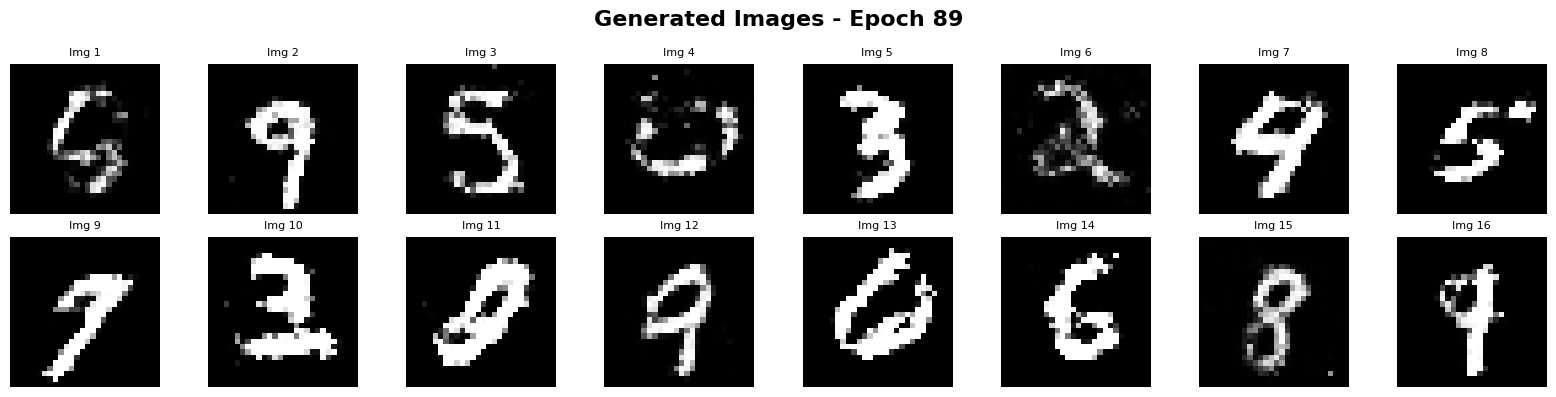


📈 Test Set Evaluation:
  • Discriminator loss: 0.6987
  • Generator loss: 0.7923
  • FID: 126.54

Epoch 90: Loss_D 0.6879426195169054, Loss_G 0.8050618814761197
Epoch 91: Loss_D 0.6880288767153775, Loss_G 0.8050627538136074
Epoch 92: Loss_D 0.6878828923585318, Loss_G 0.8040062143350206
Epoch 93: Loss_D 0.6880717732504741, Loss_G 0.8062828647048235
Epoch 94: Loss_D 0.688019280113391, Loss_G 0.8039729714647793
Epoch 95: Loss_D 0.68796075801097, Loss_G 0.8041191530634345
Epoch 96: Loss_D 0.6879082170885, Loss_G 0.8049486395138413
Epoch 97: Loss_D 0.6879525719675174, Loss_G 0.805996539114889
Epoch 98: Loss_D 0.6879773108181415, Loss_G 0.8053341091060435
Epoch 99: Loss_D 0.6881824881791561, Loss_G 0.803207221824223

📊 Evaluating at Epoch 99


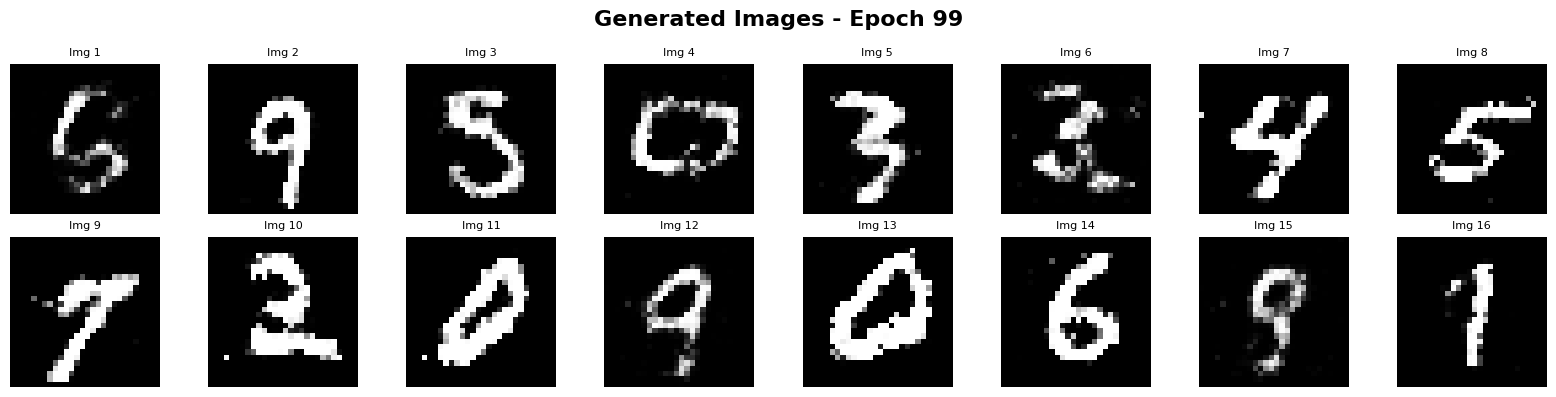


📈 Test Set Evaluation:
  • Discriminator loss: 0.6966
  • Generator loss: 0.8251
  • FID: 116.12

New best model saved! FID: 116.12
Epoch 100: Loss_D 0.6877561754255153, Loss_G 0.8052699348565612
Epoch 101: Loss_D 0.6879504602601025, Loss_G 0.8052838199428404
Epoch 102: Loss_D 0.6878243547512778, Loss_G 0.8039965149181992
Epoch 103: Loss_D 0.6878057936869705, Loss_G 0.8061824869245354
Epoch 104: Loss_D 0.6878649345847335, Loss_G 0.8050378820281039
Epoch 105: Loss_D 0.6878179657433842, Loss_G 0.8048171090927205
Epoch 106: Loss_D 0.6878458299616507, Loss_G 0.8062511978627268
Epoch 107: Loss_D 0.6877461819252225, Loss_G 0.8043151407607837
Epoch 108: Loss_D 0.6879299471119066, Loss_G 0.8034323408151232
Epoch 109: Loss_D 0.687615845630418, Loss_G 0.8071675540795967

📊 Evaluating at Epoch 109


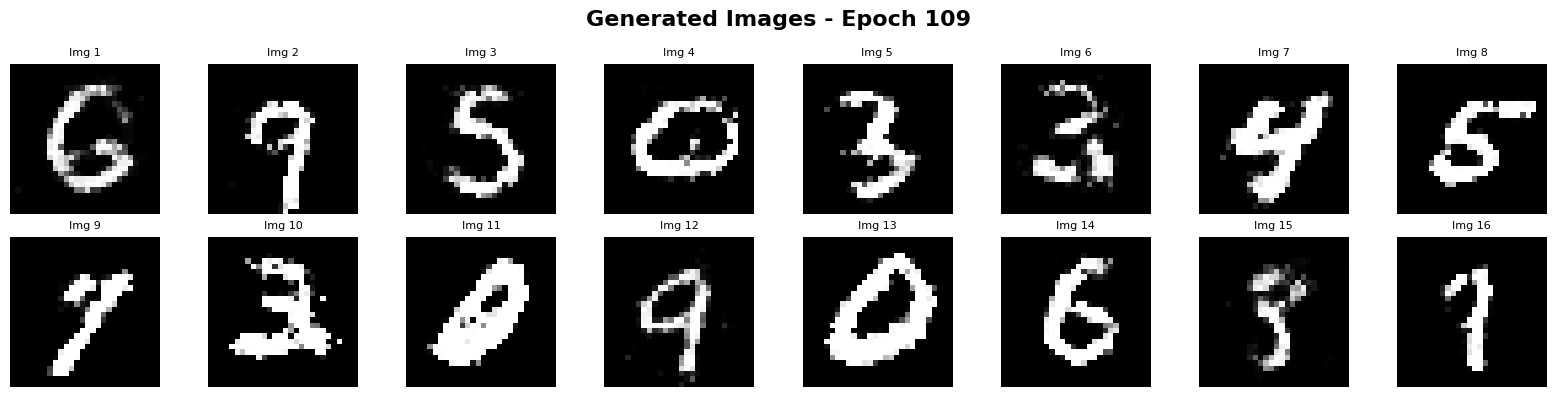


📈 Test Set Evaluation:
  • Discriminator loss: 0.6945
  • Generator loss: 0.8361
  • FID: 122.96

Epoch 110: Loss_D 0.6878904845160462, Loss_G 0.8044630289077759
Epoch 111: Loss_D 0.687818027127272, Loss_G 0.8046133705039522
Epoch 112: Loss_D 0.6879940641714312, Loss_G 0.8033710288594781
Epoch 113: Loss_D 0.6879205641461842, Loss_G 0.8036944713673866
Epoch 114: Loss_D 0.6879687370267759, Loss_G 0.8049414873377346
Epoch 115: Loss_D 0.6878411835953117, Loss_G 0.8046120544994818
Epoch 116: Loss_D 0.687900184314134, Loss_G 0.8045470115980868
Epoch 117: Loss_D 0.6876903391087742, Loss_G 0.8054225210950319
Epoch 118: Loss_D 0.6879682920889051, Loss_G 0.8040963085983862
Epoch 119: Loss_D 0.6877720270838056, Loss_G 0.8047169821857135

📊 Evaluating at Epoch 119


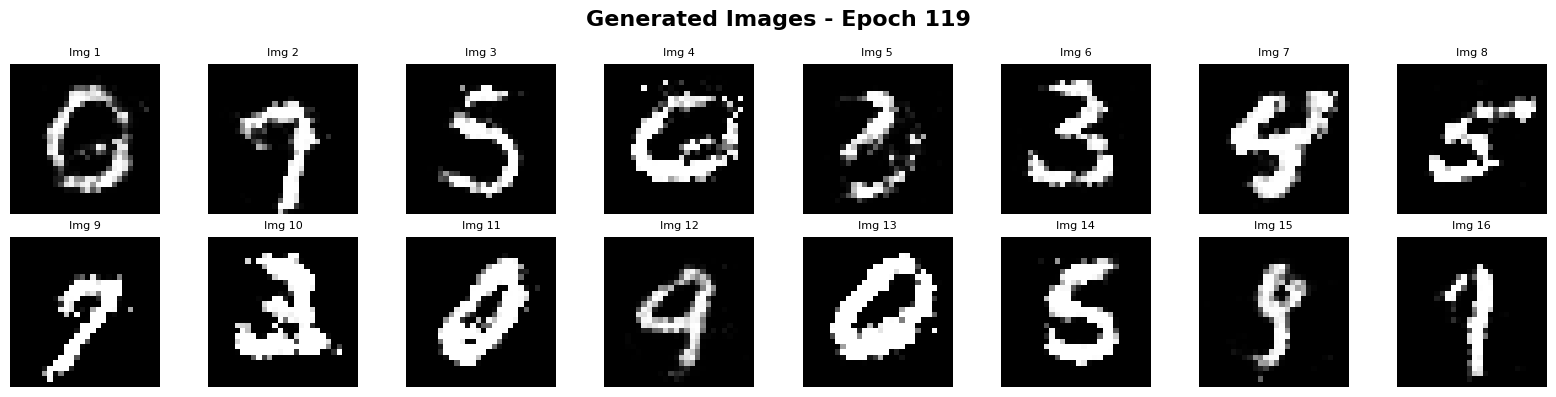


📈 Test Set Evaluation:
  • Discriminator loss: 0.6979
  • Generator loss: 0.8080
  • FID: 121.59



In [7]:

z_dim = 100
generator = Generator(z_dim).to(device)
discriminator = Discriminator().to(device)
fid_metric_global = FrechetInceptionDistance(feature=2048, normalize=True)
lr_disc = 0.0002
lr_gen = 0.0002

criterion = nn.BCELoss()
optimizer_gen = optim.Adam(generator.parameters(), lr=lr_gen, betas=(0.5, 0.999))
optimizer_disc = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(0.5, 0.999))

# Fixed noise for consistent visualization across epochs
fixed_noise = torch.randn(16, z_dim, device=device)
fixed_noise = torch.clamp(fixed_noise, -2.0, 2.0)

num_epochs = 120
n_gen_iterations = 1

losses_disc = []
losses_gen = []
fid_values = []
eval_epochs = []
eval_losses_gen = []
eval_losses_disc = []

best_fid = float('inf')

for epoch in range(num_epochs):
    generator.train()
    discriminator.train()
    
    epoch_loss_g = 0
    epoch_loss_d = 0
    num_batches = 0
    for real, _ in dataloader:
        real = real.view(-1, 28*28).to(device)

        # Train Discriminator
        loss_disc = train_disc(discriminator, generator, real, criterion,
                              optimizer_disc, z_dim, device, epoch, num_epochs)

        # Train Generator
        total_loss_gen = 0
        for _ in range(n_gen_iterations):
            loss_gen_iter = train_gen(generator, discriminator, real, criterion,
                                optimizer_gen, z_dim, device)
            total_loss_gen += loss_gen_iter

        # Accumulate losses
        epoch_loss_d += loss_disc
        epoch_loss_g += total_loss_gen / n_gen_iterations
        num_batches += 1

    # Calculate the average loss for the epoch and save it
    avg_loss_g = epoch_loss_g / num_batches
    avg_loss_d = epoch_loss_d / num_batches
    losses_gen.append(avg_loss_g)
    losses_disc.append(avg_loss_d)

    print(f"Epoch {epoch}: Loss_D {avg_loss_d}, Loss_G {avg_loss_g}")

    if (epoch + 1) % 10 == 0:
        test_metrics, fid = evaluate_gan(generator, discriminator, fid_metric_global, test_loader, criterion, fixed_noise, z_dim, epoch, device)

        eval_epochs.append(epoch)
        fid_values.append(fid)
        eval_losses_gen.append(test_metrics['loss_gen'])
        eval_losses_disc.append(test_metrics['loss_disc'])


        if fid < best_fid:
            best_fid = fid
            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_gen_state_dict': optimizer_gen.state_dict(),
                'optimizer_disc_state_dict': optimizer_disc.state_dict(),
                'fid': fid,
                'loss_gen': avg_loss_g,
                'loss_disc': avg_loss_d,
            }, 'best_gan_model.pth')
            print(f"New best model saved! FID: {fid:.2f}")

# Save metrics to CSV

In [8]:

import os

eval_metrics = {
    'epoch': eval_epochs,
    'loss_disc': eval_losses_disc,
    'loss_gen': eval_losses_gen,
    'fid': fid_values
}

training_metrics = {
    'epoch': list(range(num_epochs)),
    'loss_disc': losses_disc,
    'loss_gen': losses_gen,
}

os.makedirs('training_metrics', exist_ok=True)

df_training_metrics = pd.DataFrame(training_metrics)
df_training_metrics.to_csv('training_metrics/training_metrics.csv', index=False)

df_eval_metrics = pd.DataFrame(eval_metrics)
df_eval_metrics.to_csv('training_metrics/eval_metrics.csv', index=False)

# Plot losses

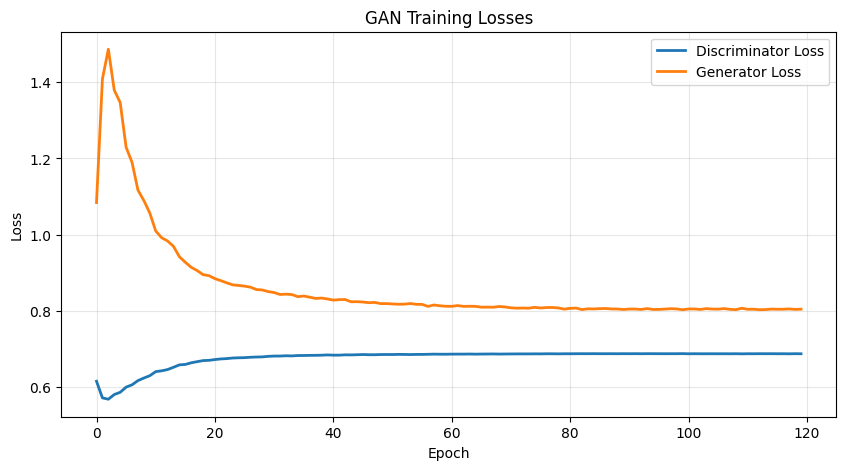

In [9]:

plt.figure(figsize=(10, 5))
plt.plot(losses_disc, label='Discriminator Loss', linewidth=2)
plt.plot(losses_gen, label='Generator Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

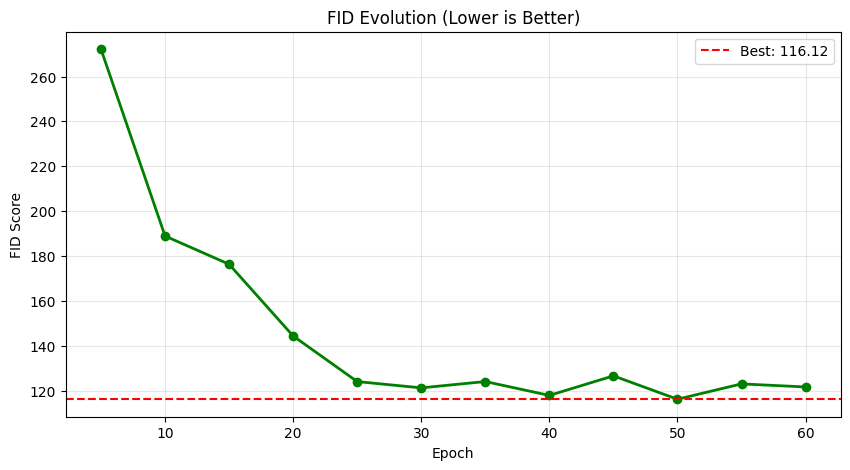

In [10]:
plt.figure(figsize=(10, 5))
epochs_fid = list(range(5, num_epochs+1, 5))[:len(fid_values)]
plt.plot(epochs_fid, fid_values, marker='o', linewidth=2, color='green')
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Evolution (Lower is Better)')
plt.grid(True, alpha=0.3)
plt.axhline(y=min(fid_values), color='r', linestyle='--', label=f'Best: {min(fid_values):.2f}')
plt.legend()
plt.show()

# Calculating Inception Score (IS) and Frèchet Inception Distance (FID)
## Create real and fake images

In [11]:

n_samples = 50
noise = torch.randn(n_samples, z_dim, device=device)
with torch.no_grad():
    gen_images = generator(noise).view(-1, 1, 28, 28)

real_images = []
for real, _ in dataloader:
    real_images.append(real)
    if len(real_images) * real.size(0) >= n_samples:
        break
real_images = torch.cat(real_images, dim=0)[:n_samples].to(device)

# Convert from grayscale to RGB
gen_images_rgb = gen_images.repeat(1, 3, 1, 1)
real_images_rgb = real_images.repeat(1, 3, 1, 1)

# Resize to 299x299 (size that Inception needs)
gen_images_299 = F.interpolate(gen_images_rgb, size=(299, 299), mode='bilinear')
real_images_299 = F.interpolate(real_images_rgb, size=(299, 299), mode='bilinear')

# Normalize to [0, 1] since they are in [-1, 1]
gen_images_299 = (gen_images_299 + 1) / 2
real_images_299 = (real_images_299 + 1) / 2

# Convert to uint8 [0, 255]
gen_images_299 = (gen_images_299 * 255).byte()
real_images_299 = (real_images_299 * 255).byte()

## Calculate Inception Score and FID using torchmetrics

In [12]:

is_metric = InceptionScore().to(device)
is_score, is_std = is_metric(gen_images_299)  # generated_images: [N, 3, 299, 299] tensor
print('Inception Score:', is_score.item())

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


Inception Score: 1.607160210609436
